In [1]:
# imports

import os
import pprint
import pickle
import glob
import json
import re
import string
import datetime
from datetime import timezone
import scipy
from scipy import stats

from collections import defaultdict

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
# utility objects

MILLISEC_PER_MONTH = 1000 * 60 * 60 * 24 * 30

pp = pprint.PrettyPrinter(indent=4)
def print_term_to_senders():
    pp.pprint(term_to_senders)
    
standard_contractions = set(["aren't", "can't", "could've", "couldn't", "didn't", 
            "doesn't", "don't", "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", 
            "how'd", "how'll", "how's", "i'd", "i'll", "i'm", "i've", "isn't", "it'd", 
            "it'll", "it's", "let's", "might've", "mightn't", "must've", 
            "mustn't", "needn't", "o'clock", "she'd", "she'll", "she's", 
            "should've", "shouldn't", "that'd", "that's", "there'd", 
            "there's", "they'd", "they'll", "they're", "they've", "wasn't", 
            "we'd", "we'll", "we're", "we've", "weren't", "what'll", "what're", "what's",
            "what've", "when's", "when've", "where'd", "where's", "where've", "who'll", 
            "who's", "who've", "why's", "won't", "would've", 
            "wouldn't", "you'd", "you'll", "you're", "you've"])

# add in all contractions without the apostrophes also
new_contractions = set()
for contraction in standard_contractions:
    new_contractions.add(contraction.replace("'", ""))

standard_contractions = standard_contractions.union(new_contractions)

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
lemmatizer = WordNetLemmatizer()

In [3]:
# helper functions

def preprocess(words):
    words = words.lower()
    # weird thing with apostrophe showing up as this unicode string
    words = re.sub("\u00e2\u0080\u0099", "'", words)
    # filter out all remaining Unicode, TODO: maybe want to translate these into emojis?
    words = words.encode("ascii", "ignore").decode("UTF-8")
    return words

def print_sorted_dict(d, first_x=None):
    sorted_keys = sorted(d, key=d.get, reverse=True)
    for i, key in enumerate(sorted_keys):
        if first_x is not None and i >= first_x:
            break
        print(f"Rank {i+1}:", key, d[key])
    return sorted_keys

def is_contraction(word):
    if "'" in word:
        split_word = word.split("'")
        if len(split_word) > 1 and split_word[0] in english_words:
            return True
    return False

terms_to_include = set(["kys"])
def exclude_word(word):
    return (len(word) < 1 or word in english_words or word.isdigit() 
            or is_contraction(word) or word in standard_contractions) and (word not in terms_to_include)

In [4]:
# load dictionary from disk

pickled_dict_fname = "term_to_senders_dict"
term_to_senders = pickle.load(open(pickled_dict_fname, "rb")) 

# {
#     "<term>": {
#         "<friend_name>": 
#             {
#                  "<friend_name>": [<list of timestamps in ms>],
#                  "<account_user_name>": [<list of timestamps in ms>]
#             }
#         ....
#     },
#     ....
# }

print(len(term_to_senders)) # should be 9998

# prints slang ranked by frequency for a single user
friend_name = "Dan J Chong"
sender_to_term_count_fname = "sender_to_term_count"
def return_zero():
    return 0
def return_dd():    
    return defaultdict(return_zero)
sender_to_term_count = pickle.load(open(sender_to_term_count_fname, "rb")) 
freq_per_friend = print_sorted_dict(sender_to_term_count[friend_name])

9998
Rank 1: lol 1242
Rank 2: fuck 454
Rank 3: ok 401
Rank 4: shit 263
Rank 5: pm 263
Rank 6: 2/15/16 258
Rank 7: ('pm', 'paschal') 258
Rank 8: gonna 237
Rank 9: wanna 151
Rank 10: wtf 148
Rank 11: lmao 130
Rank 12: kid 127
Rank 13: okay 125
Rank 14: idk 124
Rank 15: btw 117
Rank 16: nah 110
Rank 17: teh 103
Rank 18: lawrence 102
Rank 19: lmfao 100
Rank 20: xd 90
Rank 21: aditya 86
Rank 22: ('im', 'gonna') 80
Rank 23: rofl 75
Rank 24: ('lol', 'i') 62
Rank 25: email 57
Rank 26: mom 56
Rank 27: fk 55
Rank 28: addy 54
Rank 29: kinda 53
Rank 30: avi 53
Rank 31: spanish 52
Rank 32: ('holy', 'shit') 52
Rank 33: ahve 52
Rank 34: rutgers 51
Rank 35: ('the', 'fuck') 51
Rank 36: liek 51
Rank 37: jsut 51
Rank 38: korean 50
Rank 39: hte 48
Rank 40: hw 45
Rank 41: pls 44
Rank 42: kys 43
Rank 43: ('oh', 'shit') 41
Rank 44: haha 41
Rank 45: fuckign 41
Rank 46: km 40
Rank 47: jk 37
Rank 48: ('you', 'guys') 36
Rank 49: ('wanted', 'to') 35
Rank 50: omg 35
Rank 51: bro 34
Rank 52: woudl 34
Rank 53: hang 

In [5]:
# define terms for analysis
msg_dir = "/home/lhuang21/Documents/SideProjects/Grapevine/facebook-lawrenceh1850/messages/inbox"
account_user_name = "Lawrence Huang"
# terms where I influenced friend
# TERM = "wtf"
# TERM = "okay"

# 0 correlation
# TERM = "lol"
# TERM = "ok"

# terms where friend influenced me
# TERM = ("holy", "shit")
# TERM = ("shit")
# TERM = ("lmao")
# TERM = ("xd")
FRIEND_NAME = "Dan J Chong"

In [6]:
# calculate moving average

def term_freq_avg(start_time_milli, end_time_milli, term, friend_name, msg_dir):
    """
    Calculates average term frequency per word in a given time frame for all users involved in conversation.
    """
    if start_time_milli > end_time_milli:
        raise ValueError("End time must be after start time.")
    
    dir_prefix = friend_name.strip().replace(" ", "").lower()
    msg_file_path = os.path.join(msg_dir, dir_prefix + "*")
    candidate_dirs = glob.glob(msg_file_path)
    
    # this is for determining whether the term is a single word
    # bigram or trigram
    term_dimension = 1
    if isinstance(term, tuple):
        term_dimension = len(term)
    
    if len(candidate_dirs) != 1:
        raise ValueError("Invalid path for friend name and message directory specified")
    else:
        msg_file_path = os.path.join(candidate_dirs[0], "message_1.json") 
        
        # make sure file exists
        if not os.path.exists(msg_file_path):
            raise ValueError(f"{msg_file_path} doesn't exist")
        else:
            json_dict = json.load(open(msg_file_path, 'r'))

            word_count_in_period = {}
            term_count_in_period = {}
            
            for name_dict in json_dict["participants"]:
                participant_name = name_dict["name"]
                term_count_in_period[participant_name] = 0
                word_count_in_period[participant_name] = 0

            for index, msg in enumerate(reversed(json_dict['messages'])):
                msg_timestamp_ms = msg["timestamp_ms"]
                sender = msg["sender_name"]
                
                if msg_timestamp_ms >= start_time_milli:
                    if msg_timestamp_ms > end_time_milli:
                        break
                    
                    try:
                        content = preprocess(msg["content"])
                    except KeyError:
                        # in case there isn't a content key
                        continue
                    tok_content = content.split()
                    
                    word_count_in_period[sender] += len(tok_content)
                    
                    if term_dimension == 1:
                        # monograms
                        for word in tok_content:
                            word = word.strip(string.punctuation)
                            if len(word) > 0:
                                # only lemmatize if this was not a hand-picked word
                                if word not in terms_to_include:
                                    word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                                if word == term:
                                    term_count_in_period[sender] += 1
                    elif term_dimension == 2:
                        # bigrams
                        for (tok1, tok2) in ngrams(tok_content, 2):
                            tok1 = tok1.strip(string.punctuation)
                            tok2 = tok2.strip(string.punctuation)
                            if term == (tok1, tok2):
                                term_count_in_period[sender] += 1
                    elif term_dimension == 3:
                        # trigrams
                        for (tok1, tok2, tok3) in ngrams(tok_content, 3):
                            tok1 = tok1.strip(string.punctuation)
                            tok2 = tok2.strip(string.punctuation)
                            tok3 = tok3.strip(string.punctuation)
                            if term == (tok1, tok2, tok3):
                                term_count_in_period[sender] += 1
                    else:
                        raise ValueError(f"Term has invalid input dimension")
                        
            for sender in term_count_in_period:
                if word_count_in_period[sender] != 0:
                    term_count_in_period[sender] /= float(word_count_in_period[sender])
                else:
                    # sender had no words in this period
                    term_count_in_period[sender] = 0
                
            return term_count_in_period

In [7]:
# DON'T RUN IF YOU DON'T WANT TO OVERWRITE, graph each term, write term_to_usage_rates to disk
# TODO: make a nice input box for that

print("Term to usage rates exists already.")
user_input = None
while user_input is None or not (user_input == "y" or user_input == "n"):
    user_input = input("Redo analysis (y/n)? ").lower()
if user_input == "y":
    redo_analysis = True
else:
    redo_analysis = False


term_to_usage_rates_fname = "term_to_usage_rates"
term_to_usage_rates = {}
term_to_usage_rates[FRIEND_NAME] = FRIEND_NAME
# { 
#   "FRIEND_NAME": "",
#   term_1: {
#     "friend_usage_rates": [ ... ],
#     "user_usage_rates": [ ... ],
#     "x_axis": x_axis
#   },
#   term_2 : {
#     ...
#   }
# ...
# }
    
if redo_analysis:
    for TERM in freq_per_friend:    
        friend_timestamps = term_to_senders[TERM][FRIEND_NAME][FRIEND_NAME]
        user_timestamps = term_to_senders[TERM][FRIEND_NAME][account_user_name]

        first_mention = None
        last_mention = None
        # no mentions
        if len(friend_timestamps) == 0 and len(user_timestamps) == 0:
            pass
        elif len(friend_timestamps) == 0:
            first_mention = user_timestamps[0]
            last_mention = user_timestamps[0]
        elif len(user_timestamps) == 0:
            first_mention = friend_timestamps[0]
            last_mention = friend_timestamps[0]
        else:
            first_mention = min(friend_timestamps[0], user_timestamps[0])
            last_mention = max(friend_timestamps[-1], user_timestamps[-1])

        # calculate usage rates across time period
        if first_mention is not None and last_mention is not None:
            x_axis = []
            friend_usage_rates = []
            user_usage_rates = []

            START_MS = first_mention
            END_MS = START_MS + MILLISEC_PER_MONTH

            while START_MS <= last_mention:
                rate_dict = term_freq_avg(START_MS, END_MS, TERM, FRIEND_NAME, msg_dir)
                START_MS = END_MS
                END_MS = START_MS + MILLISEC_PER_MONTH
                x_axis.append(datetime.datetime.utcfromtimestamp(START_MS / 1000).replace(tzinfo=datetime.timezone.utc))
                friend_usage_rates.append(rate_dict[FRIEND_NAME])
                user_usage_rates.append(rate_dict[account_user_name])

            term_to_usage_rates[TERM] = {
                "friend_usage_rates": friend_usage_rates,
                "user_usage_rates": user_usage_rates,
                "x_axis": x_axis
            }
            pickle.dump(term_to_usage_rates, open(term_to_usage_rates_fname, "wb"))
        else:
            raise ValueError(f"Should not reach here: No mentions of {TERM} found for {FRIEND_NAME}")

        # TODO: implement geometric weighting or some sort of moving average for earlier difference terms
        # maybe even just some sort of cutoff to account for noise
        # also the case where initial usage was relatively the same ad then later one person stopped 
        # but the first person continued, maybe have to take into account the absolute value of the usage rate
        # like if it was 0 for both people at some point that's kind of an edge case (see "kid")

Term to usage rates exists already.
Redo analysis (y/n)? n


Friend name: Dan J Chong
TERM: lol
Influence score: 0.0017054257473073963
user_base_rate: 0.009121833333806907
friend_base_rate: 0.011327747076030835
base_difference_rate: -0.0022059137422239276
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


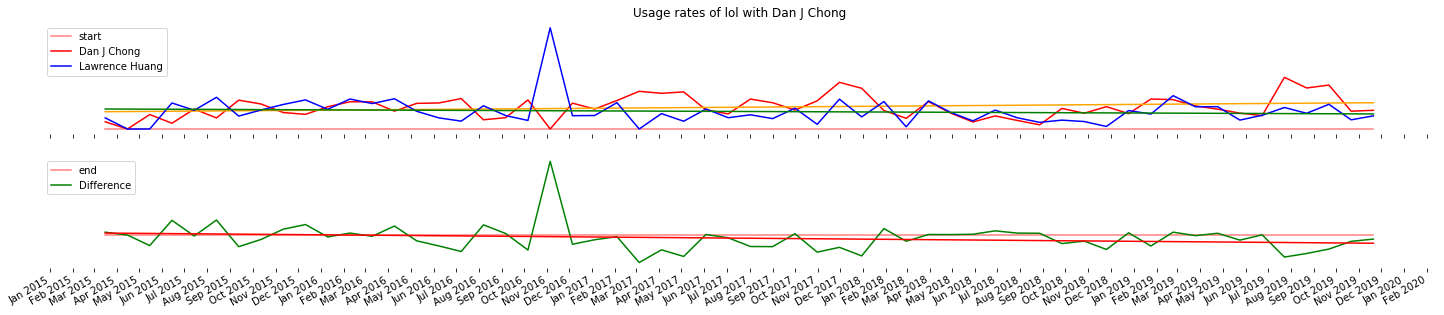

TERM: fuck
Influence score: -0.0008070164425287856
user_base_rate: 8.648602209781835e-05
friend_base_rate: 0.004721331141014053
base_difference_rate: -0.004634845118916235
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


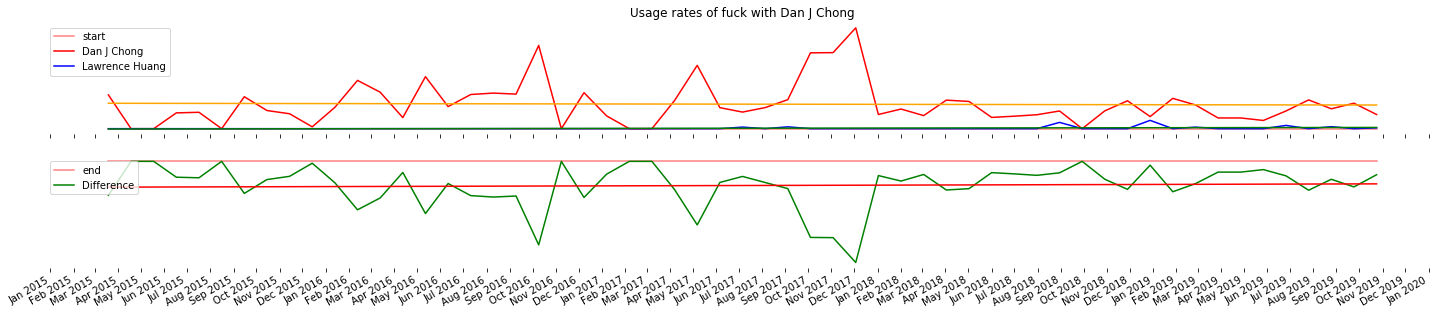

TERM: ok
Influence score: -0.0023738104992483723
user_base_rate: 0.0064111715856476886
friend_base_rate: 0.004559583116655726
base_difference_rate: 0.0018515884689919628
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


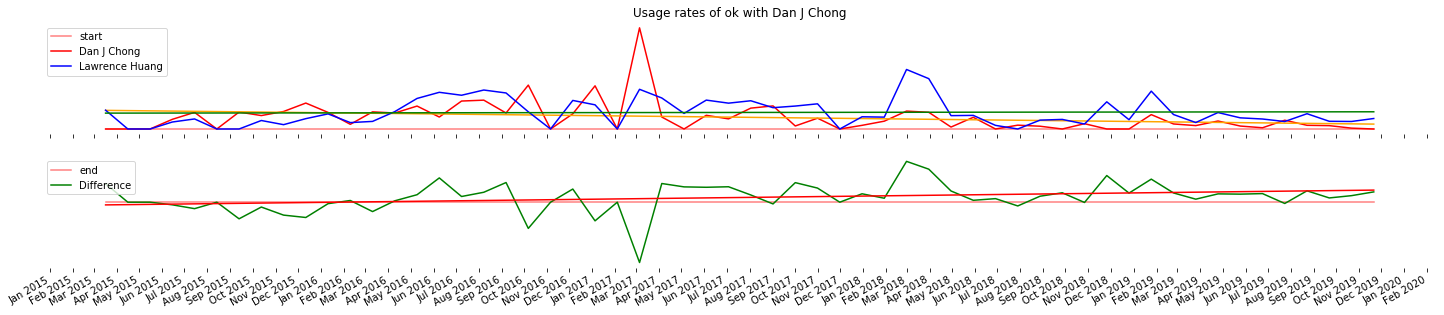

TERM: shit
Influence score: -0.0033672332013558676
user_base_rate: 0.00025650405304297394
friend_base_rate: 0.0026377602719661014
base_difference_rate: -0.002381256218923127
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


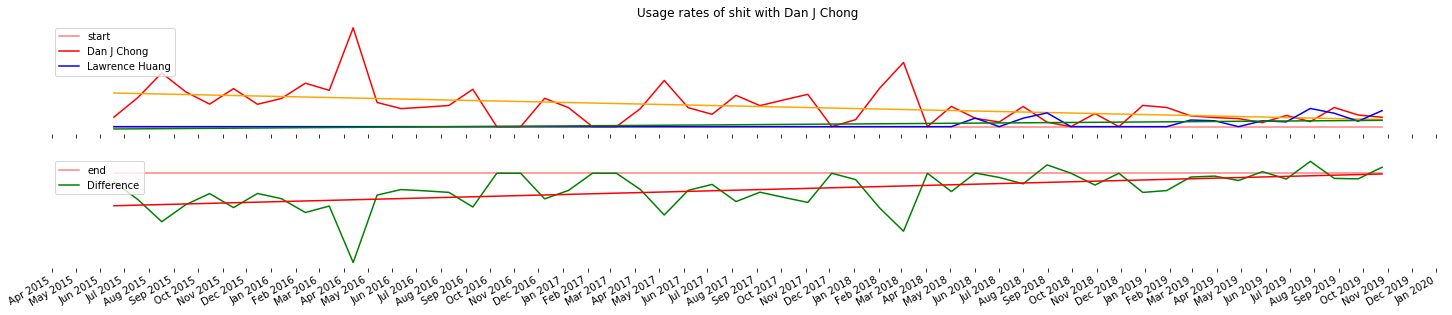

TERM: gonna
Influence score: -0.000519486415005154
user_base_rate: 0.00365147502202549
friend_base_rate: 0.0023887085989197244
base_difference_rate: 0.0012627664231057657
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


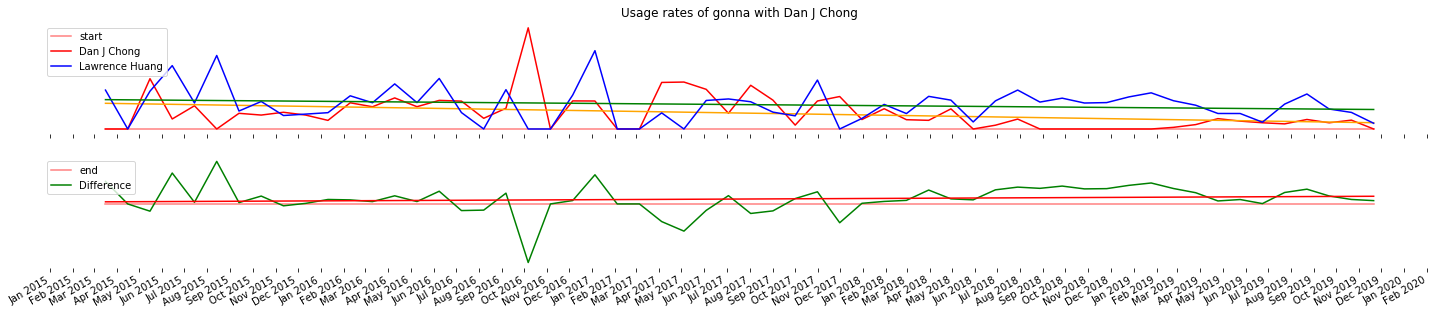

TERM: wanna
Influence score: -0.00021253537274051418
user_base_rate: 0.0021081466140870082
friend_base_rate: 0.0015624394074995483
base_difference_rate: 0.0005457072065874599
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


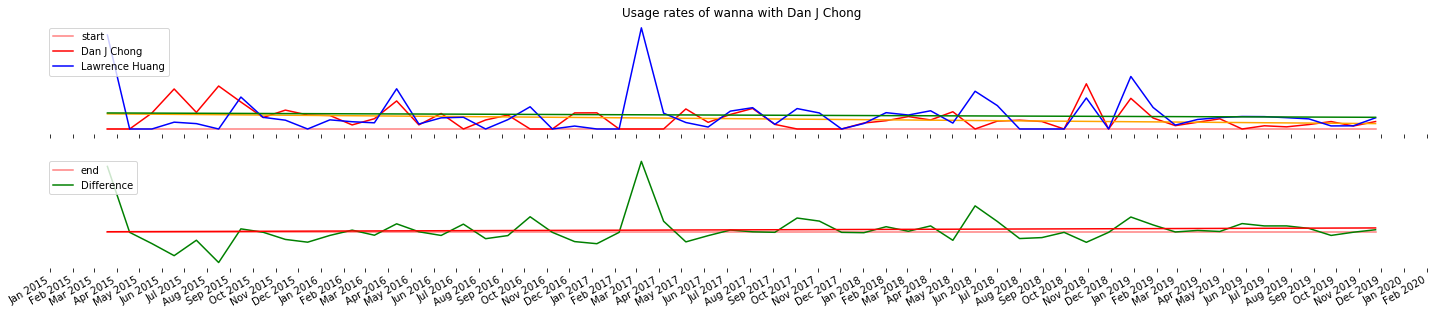

TERM: wtf
Influence score: -0.0011359250436133287
user_base_rate: 0.0008701220811105618
friend_base_rate: 0.0014329930115590593
base_difference_rate: -0.0005628709304484977
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


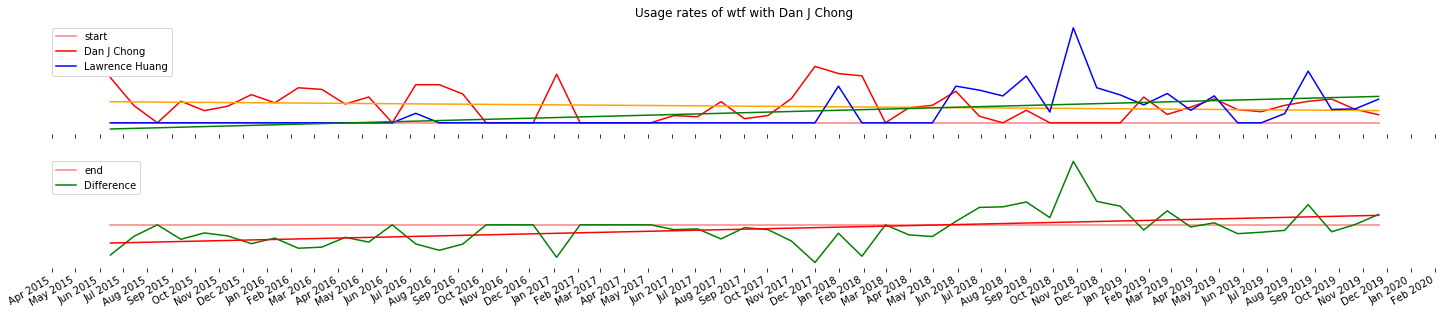

TERM: lmao
Influence score: -0.0026739833384452566
user_base_rate: 0.004238505874020935
friend_base_rate: 0.0014867852080722146
base_difference_rate: 0.002751720665948721
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


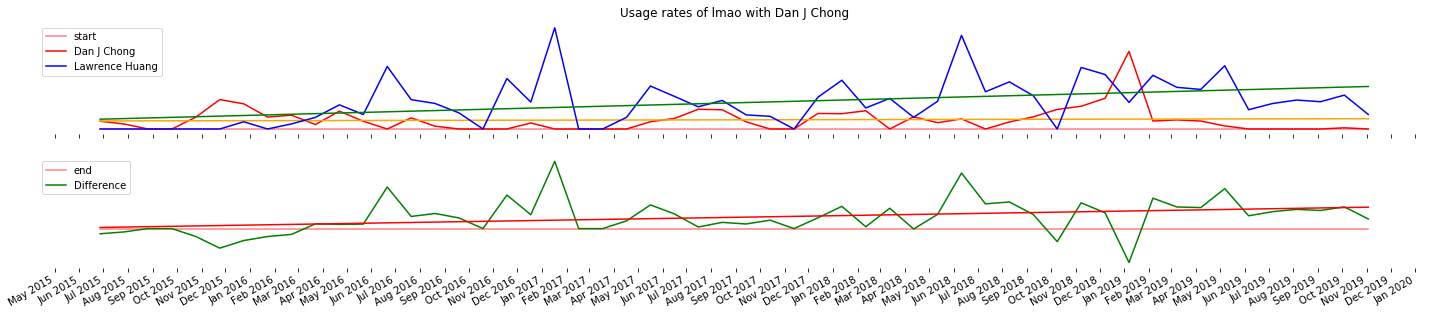

TERM: kid
Influence score: -0.00239618030354243
user_base_rate: 0.0007317292712835631
friend_base_rate: 0.0014201591751043551
base_difference_rate: -0.0006884299038207919
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


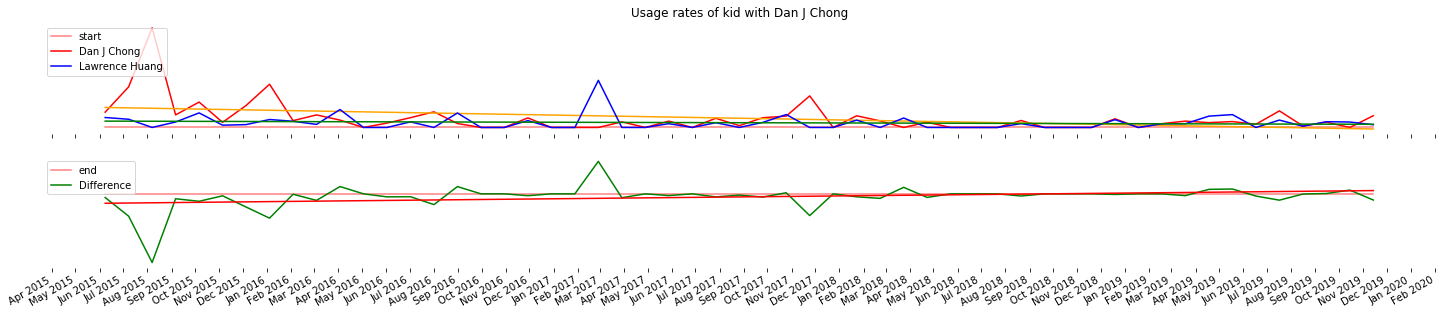

TERM: okay
Influence score: 0.0011805822014703366
user_base_rate: 0.0005304420224163697
friend_base_rate: 0.0012593463926028705
base_difference_rate: -0.0007289043701865009
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


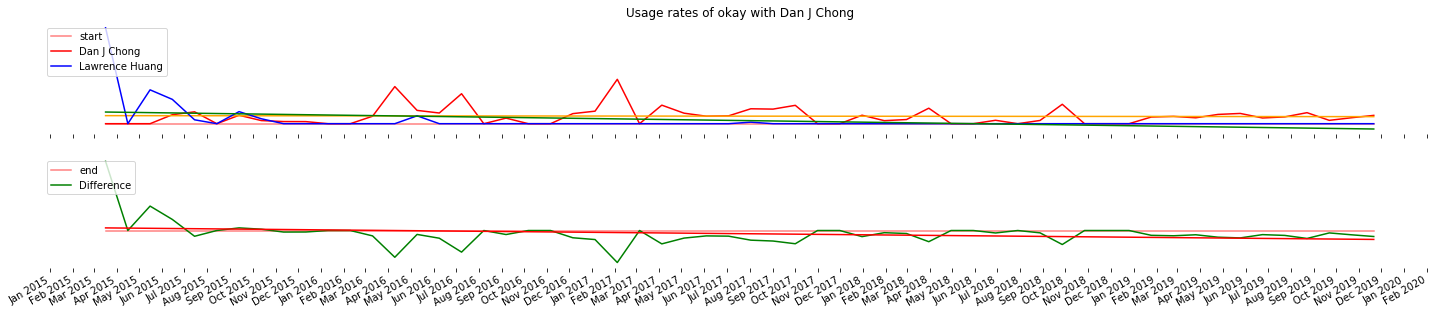

TERM: idk
Influence score: 0.0011883534602340916
user_base_rate: 0.0026371730600389665
friend_base_rate: 0.0013434471484909231
base_difference_rate: 0.0012937259115480436
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


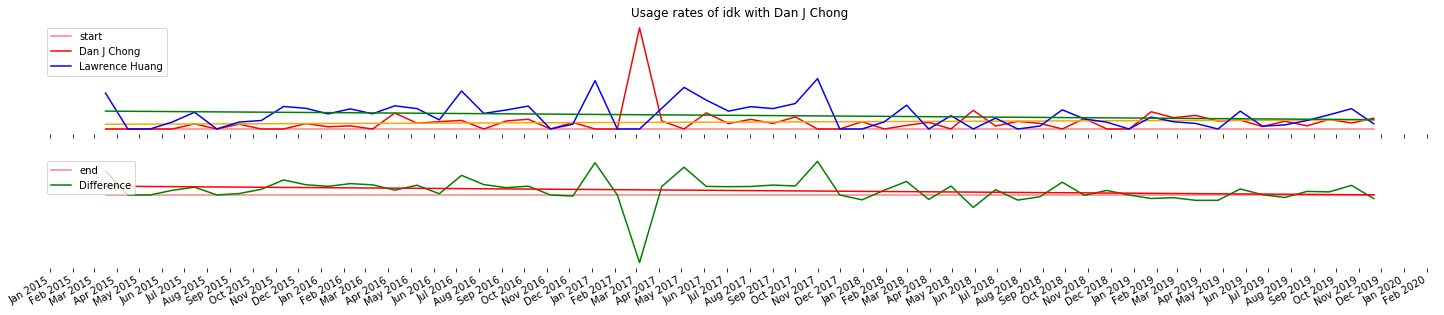

TERM: btw
Influence score: -0.0004531455548589596
user_base_rate: 0.00021312930308865278
friend_base_rate: 0.0012909771334051684
base_difference_rate: -0.0010778478303165152
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


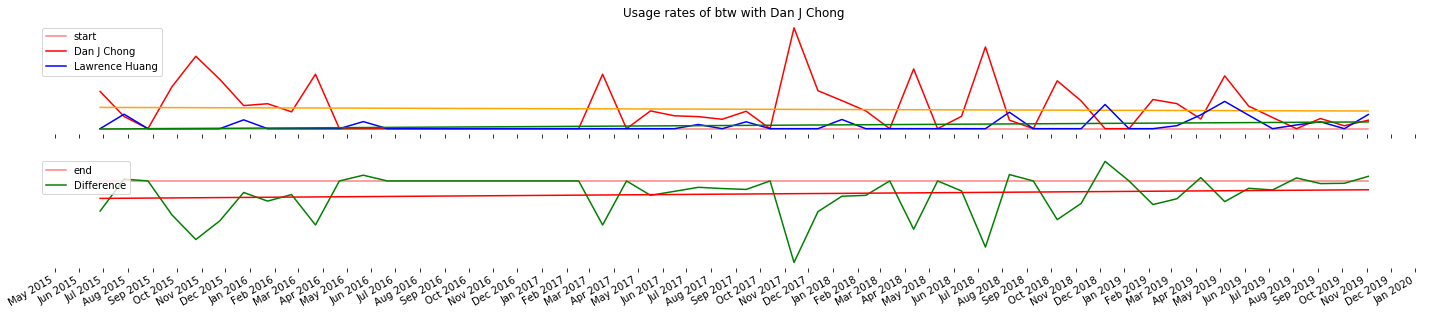

TERM: nah
Influence score: 0.000361076053014897
user_base_rate: 0.0025955227759263924
friend_base_rate: 0.0010852549720095587
base_difference_rate: 0.0015102678039168342
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


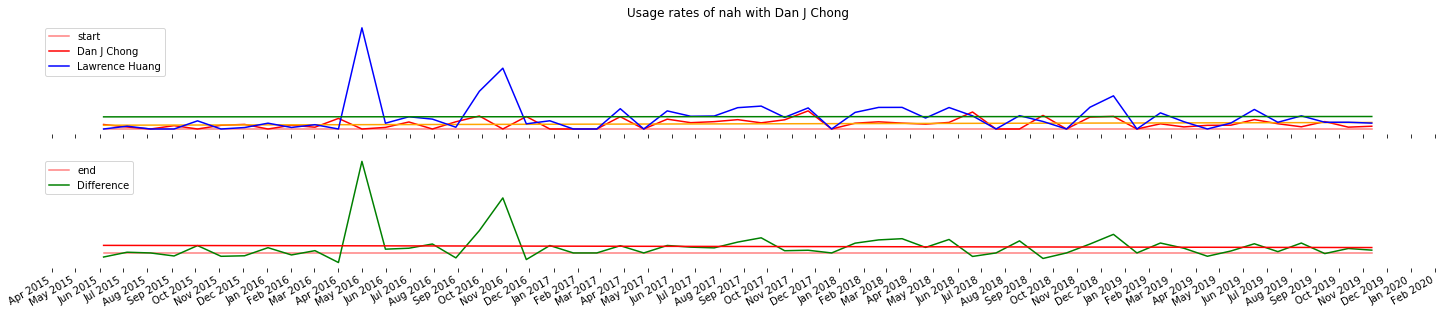

TERM: lawrence
Influence score: 0.0010696467006657004
user_base_rate: 0.00014187788385613997
friend_base_rate: 0.0013762763923248073
base_difference_rate: -0.0012343985084686672
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


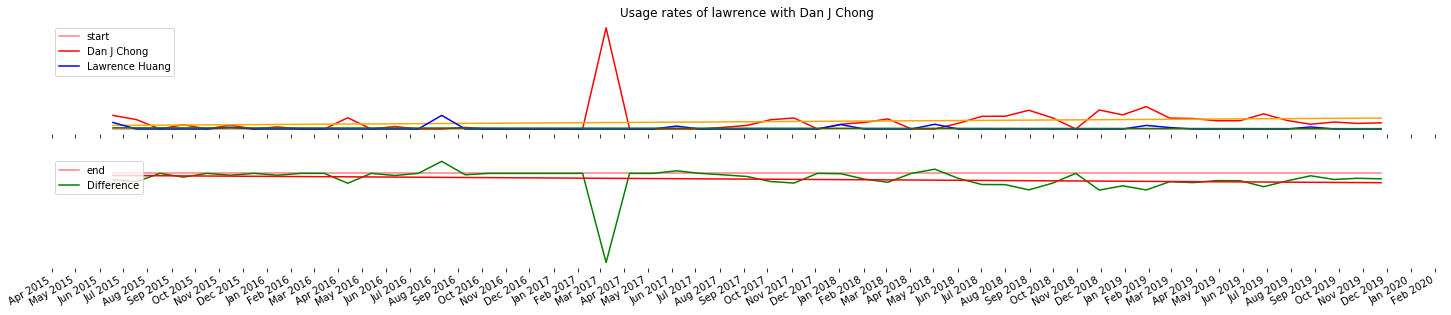

TERM: lmfao
Influence score: 6.837702028673102e-05
user_base_rate: 3.1115441698613275e-05
friend_base_rate: 0.0014236337339074692
base_difference_rate: -0.0013925182922088558
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


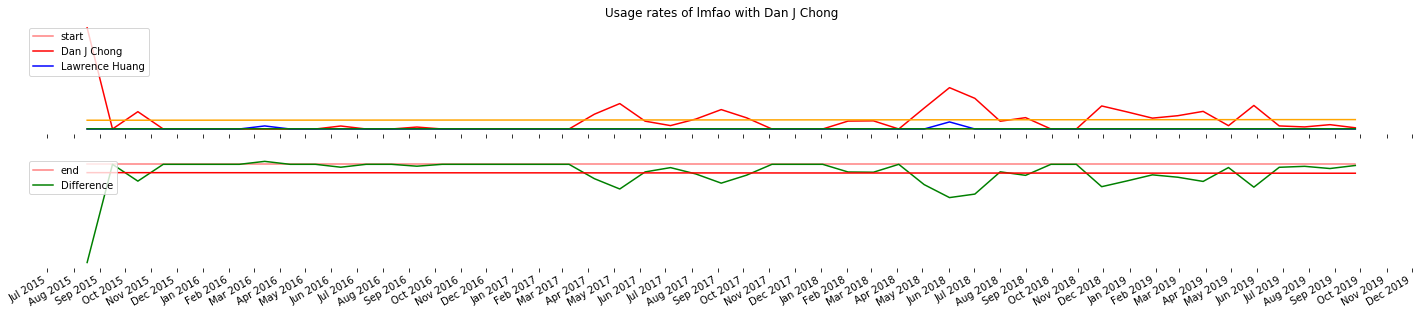

TERM: xd
Influence score: -0.00010672775928112395
user_base_rate: 0.00043705287647798286
friend_base_rate: 0.0010746705202205591
base_difference_rate: -0.0006376176437425761
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


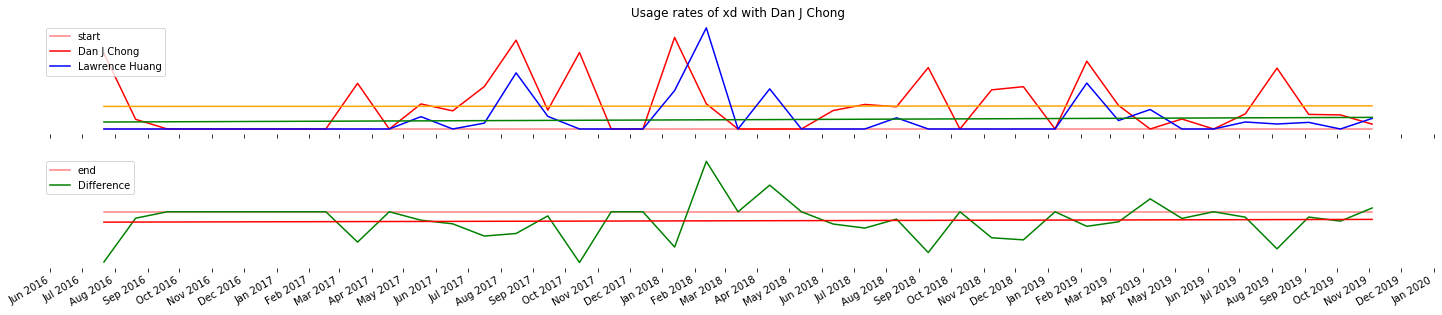

TERM: aditya
Influence score: 0.0011491883744656182
user_base_rate: 0.00036099607663050965
friend_base_rate: 0.0012305213212556653
base_difference_rate: -0.0008695252446251558
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


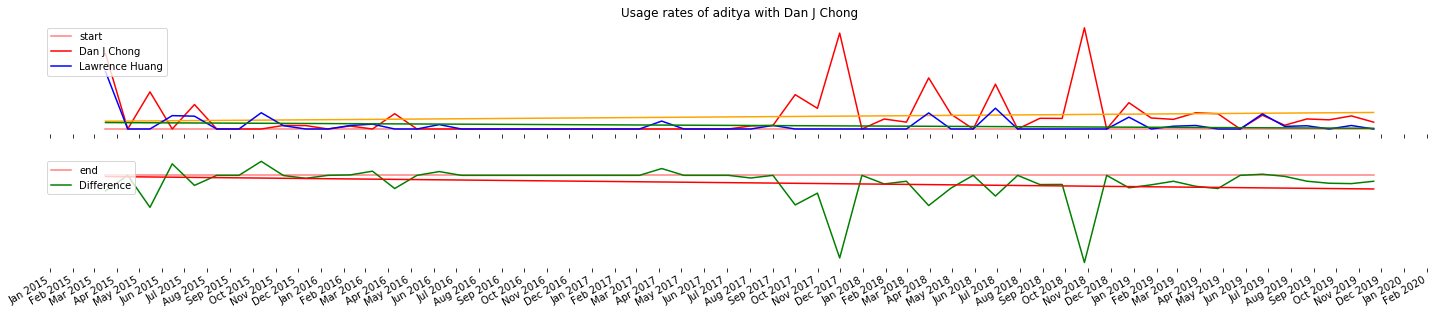

TERM: ('im', 'gonna')
Influence score: -0.0005415409161208219
user_base_rate: 0.0005995660262650887
friend_base_rate: 0.0009174263999482869
base_difference_rate: -0.00031786037368319837
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


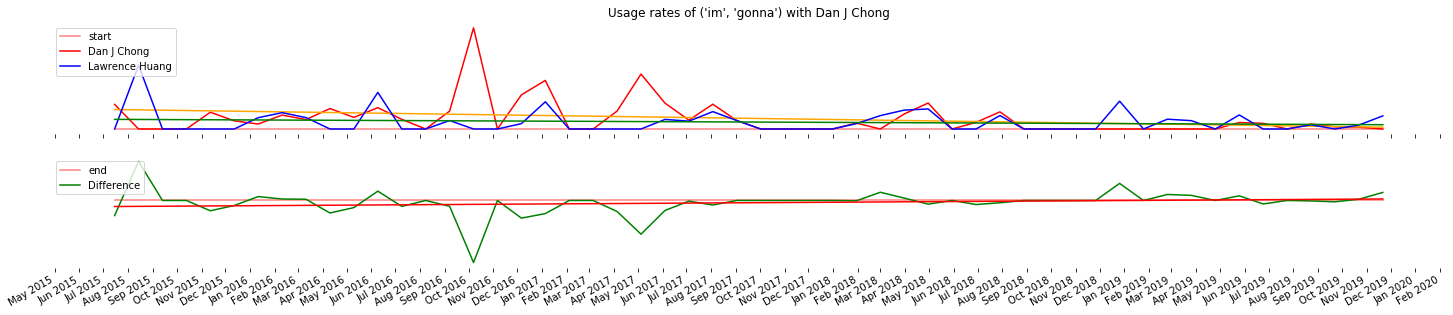

TERM: rofl
Influence score: 0.0018392358865909834
user_base_rate: 2.563774208795854e-05
friend_base_rate: 0.0010947934456733976
base_difference_rate: -0.001069155703585439
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


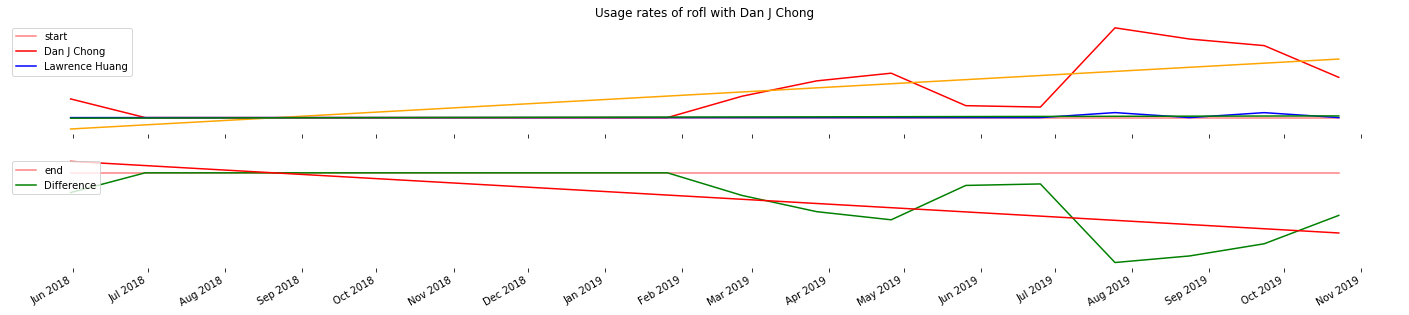

TERM: ('lol', 'i')
Influence score: -0.00026396829141319393
user_base_rate: 0.0005942066202072374
friend_base_rate: 0.0007233412687561434
base_difference_rate: -0.00012913464854890592
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


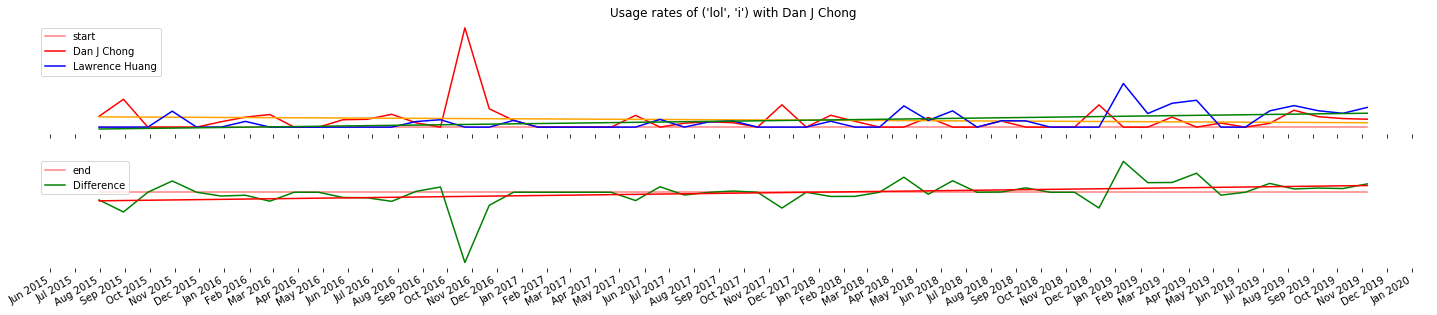

TERM: email
Influence score: 0.00035206824666431715
user_base_rate: 0.0004886495586281395
friend_base_rate: 0.0006696120487840092
base_difference_rate: -0.00018096249015586965
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


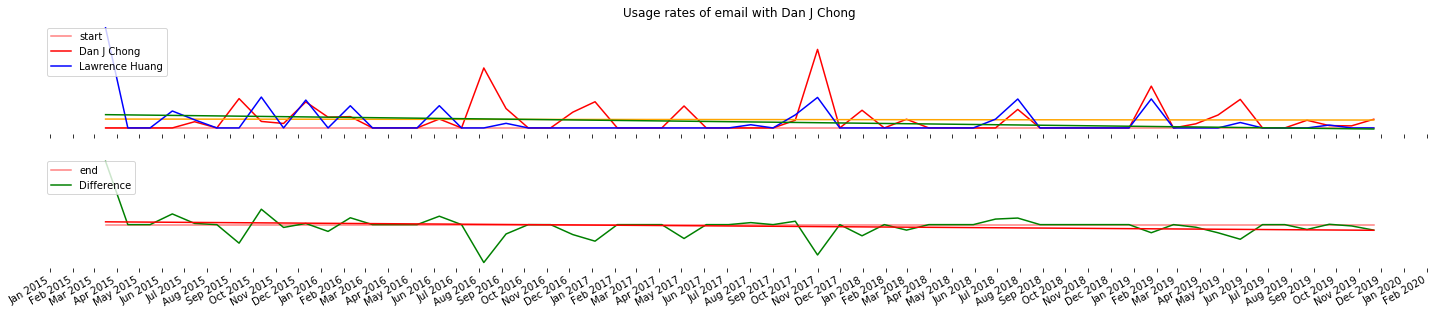

TERM: mom
Influence score: 0.0002866461879071819
user_base_rate: 0.0006028118111702263
friend_base_rate: 0.0007210043090856775
base_difference_rate: -0.00011819249791545151
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


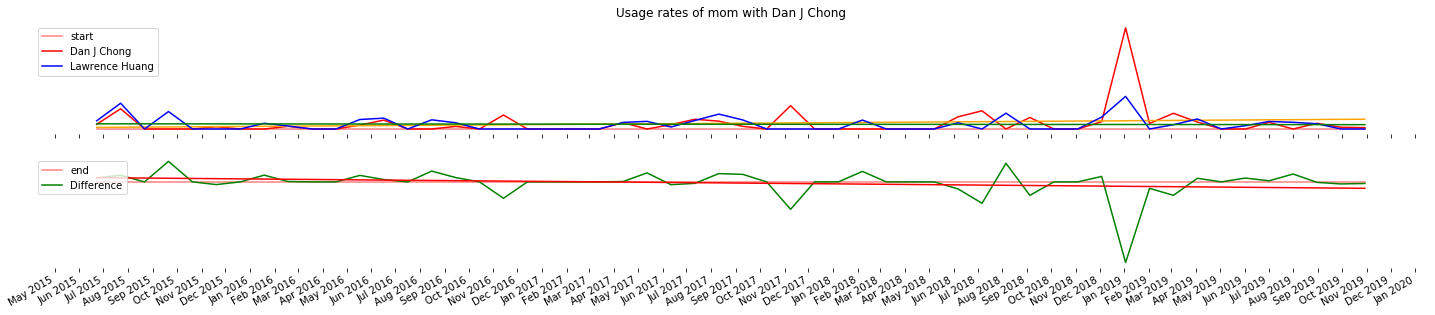

TERM: fk
Influence score: -0.0005670478822480718
user_base_rate: 0.00034968505962326506
friend_base_rate: 0.00044915220871848886
base_difference_rate: -9.94671490952238e-05
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


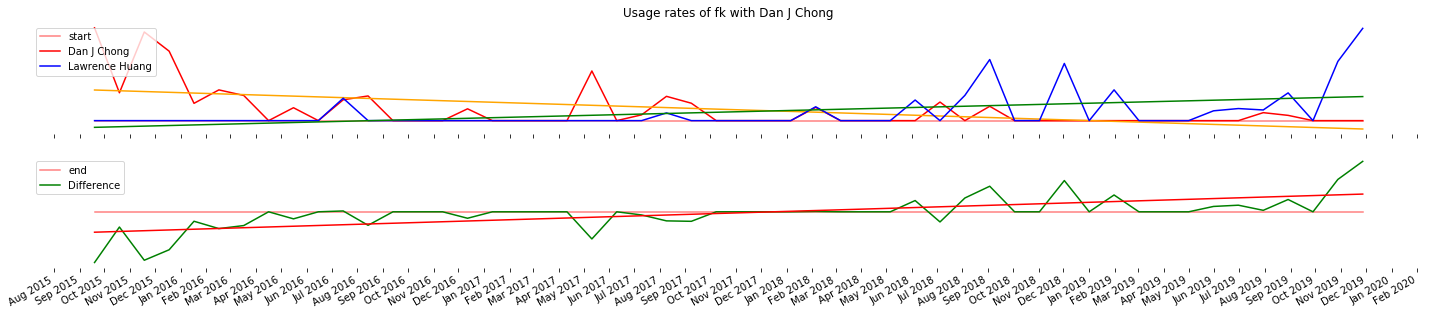

TERM: addy
Influence score: -0.00031910419521810135
user_base_rate: 0.0009314948469356747
friend_base_rate: 0.0006328798326636137
base_difference_rate: 0.0002986150142720612
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


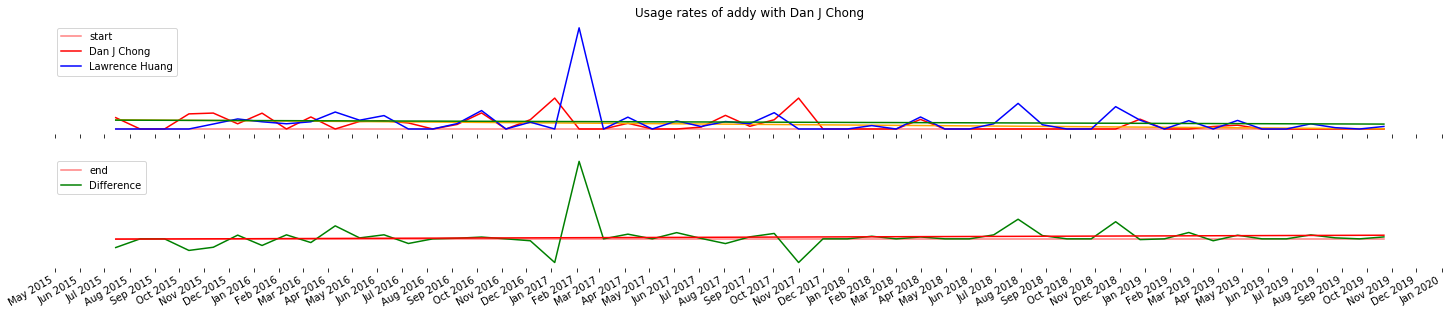

TERM: kinda
Influence score: -0.00024958469893880263
user_base_rate: 0.0008246553681981004
friend_base_rate: 0.0005040013325900901
base_difference_rate: 0.0003206540356080104
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


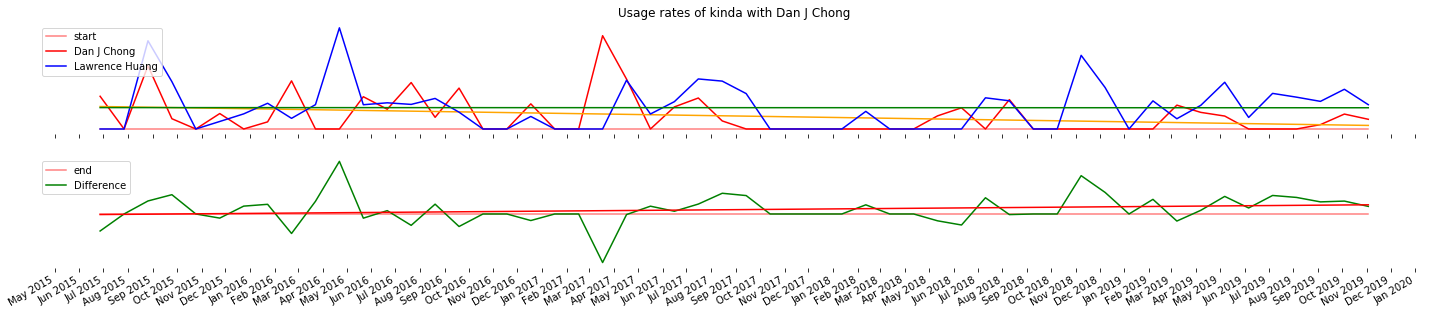

TERM: avi
Influence score: 0.0006983110641420191
user_base_rate: 0.0007462177289761294
friend_base_rate: 0.0005670433457547498
base_difference_rate: 0.00017917438322137967
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


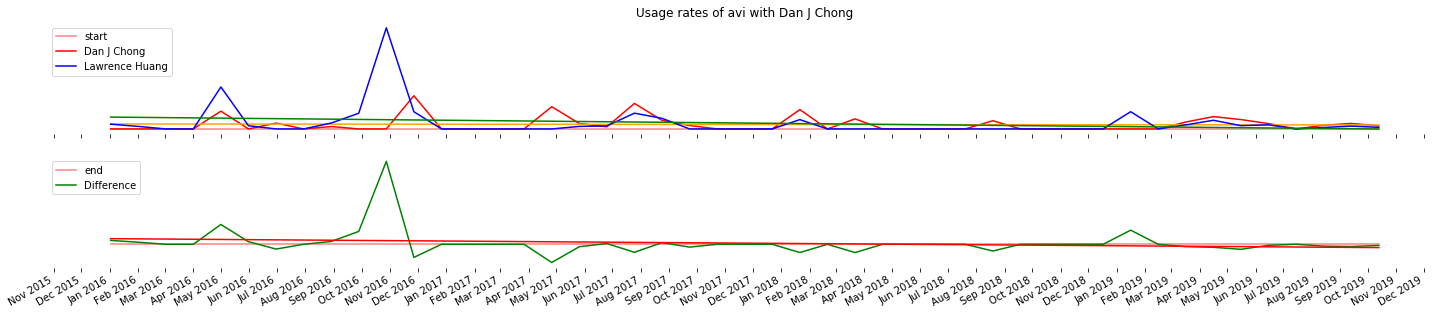

TERM: ('holy', 'shit')
Influence score: -0.0007021898863292142
user_base_rate: 2.2878569698083237e-05
friend_base_rate: 0.00047514083728256883
base_difference_rate: -0.0004522622675844856
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


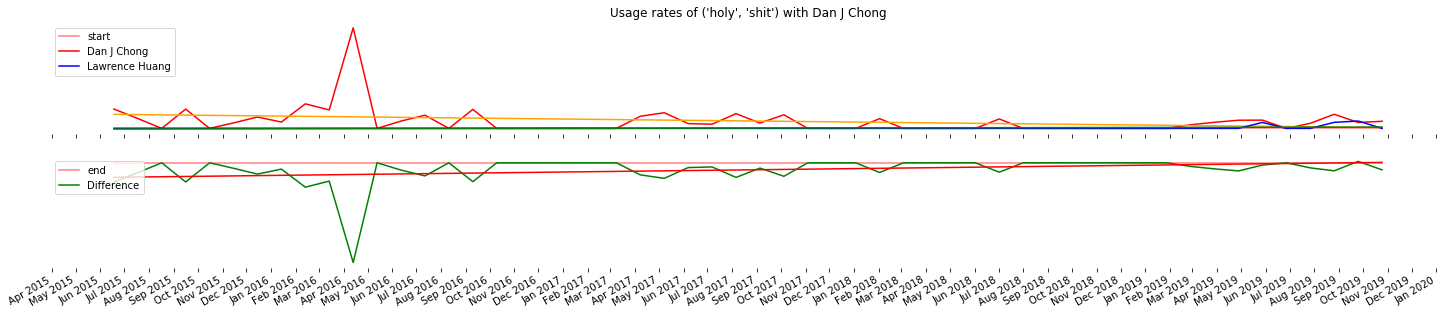

TERM: rutgers
Influence score: 0.00020176689705423401
user_base_rate: 0.0005523799231111376
friend_base_rate: 0.0003850328947485407
base_difference_rate: 0.0001673470283625968
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


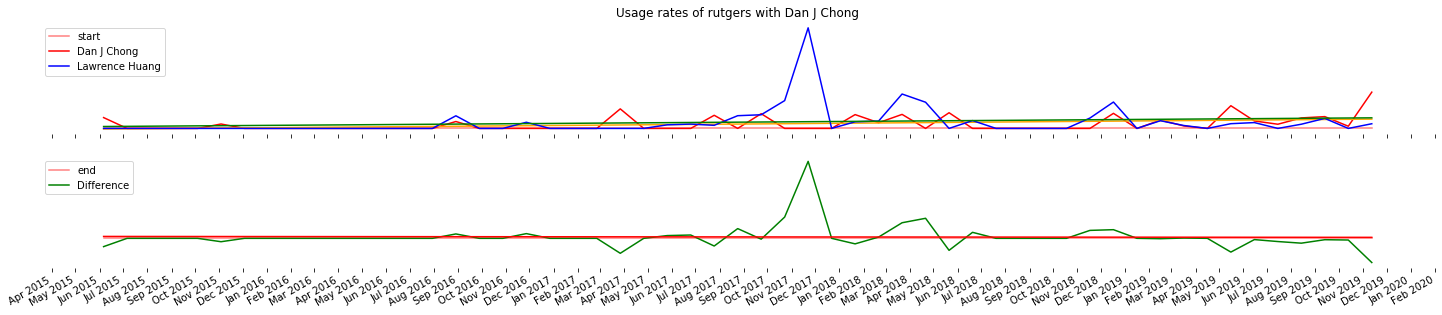

TERM: ('the', 'fuck')
Influence score: -6.501269769586002e-05
user_base_rate: 2.6950546927279007e-05
friend_base_rate: 0.0005422458256643322
base_difference_rate: -0.0005152952787370531
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


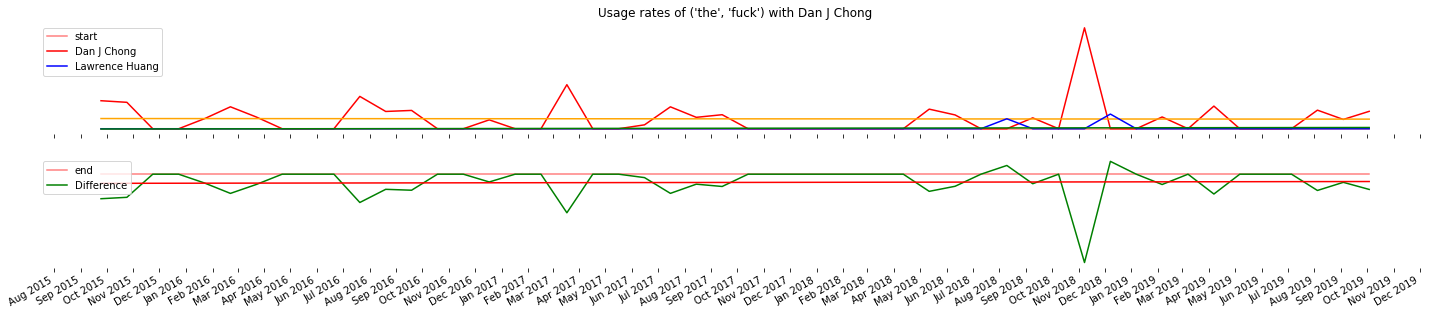

TERM: korean
Influence score: -3.624782382620517e-05
user_base_rate: 0.0004193820405657492
friend_base_rate: 0.0003740897694402578
base_difference_rate: 4.52922711254915e-05
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


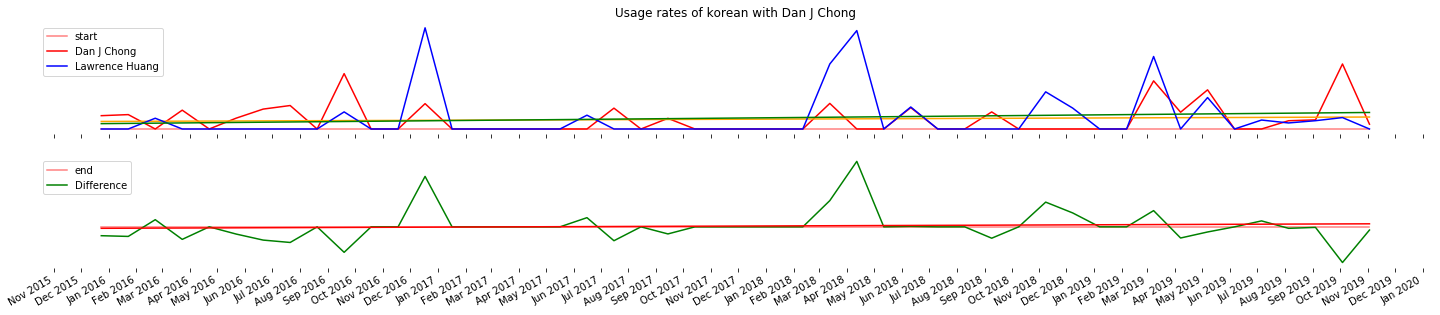

TERM: pls
Influence score: -0.00043412230649820534
user_base_rate: 0.0007590286390259802
friend_base_rate: 0.0005853900472242985
base_difference_rate: 0.0001736385918016816
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


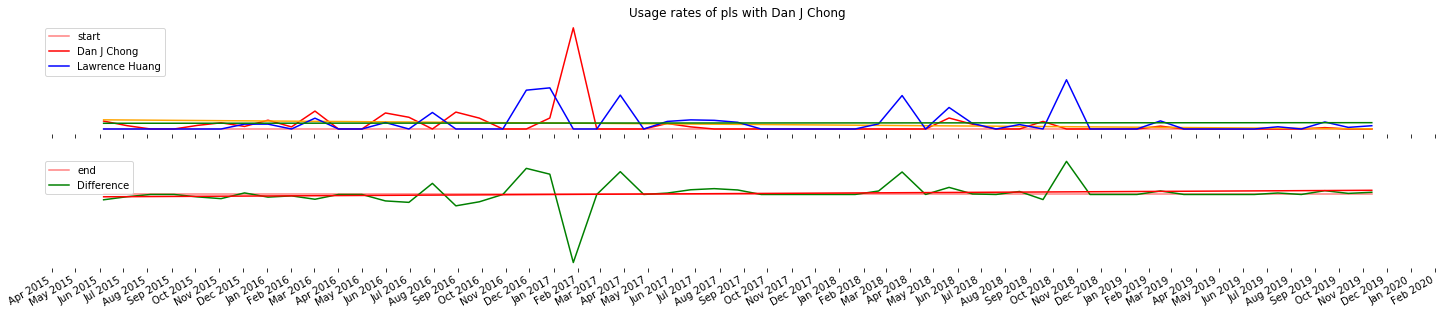

TERM: kys
Influence score: 0.00021241770413944487
user_base_rate: 0.0006548673998873513
friend_base_rate: 0.0005862999934416698
base_difference_rate: 6.856740644568148e-05
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


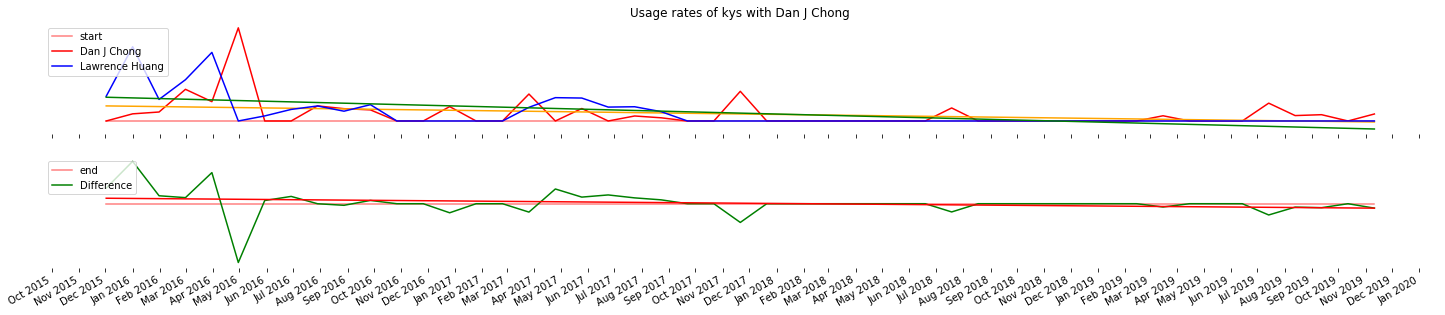

TERM: ('oh', 'shit')
Influence score: -0.00016879680573073387
user_base_rate: 1.4352067258951249e-05
friend_base_rate: 0.00036491430511809234
base_difference_rate: -0.0003505622378591411
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


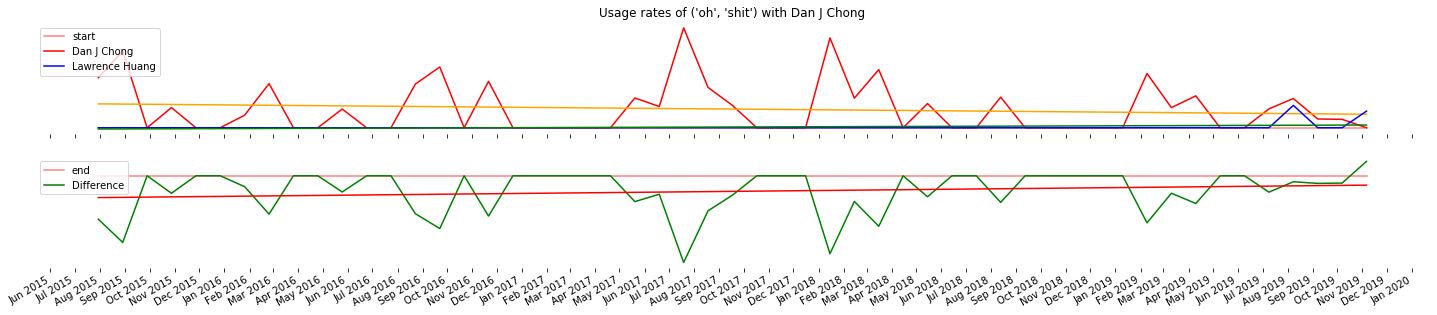

TERM: haha
Influence score: 0.0004704794091707876
user_base_rate: 4.781258794885448e-05
friend_base_rate: 0.000818931587141483
base_difference_rate: -0.0007711189991926283
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


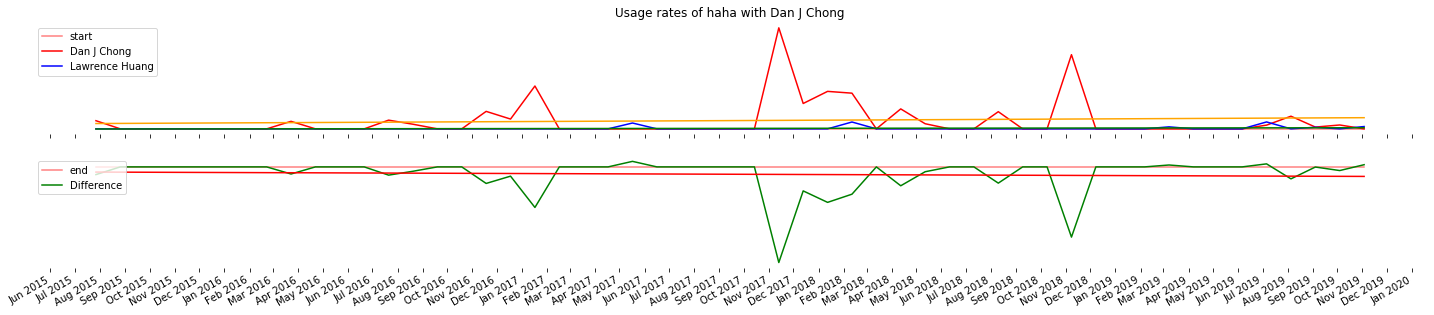

TERM: km
Influence score: -0.0003696938336316408
user_base_rate: 0.00040486735013913887
friend_base_rate: 0.00035870155930998966
base_difference_rate: 4.6165790829149165e-05
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


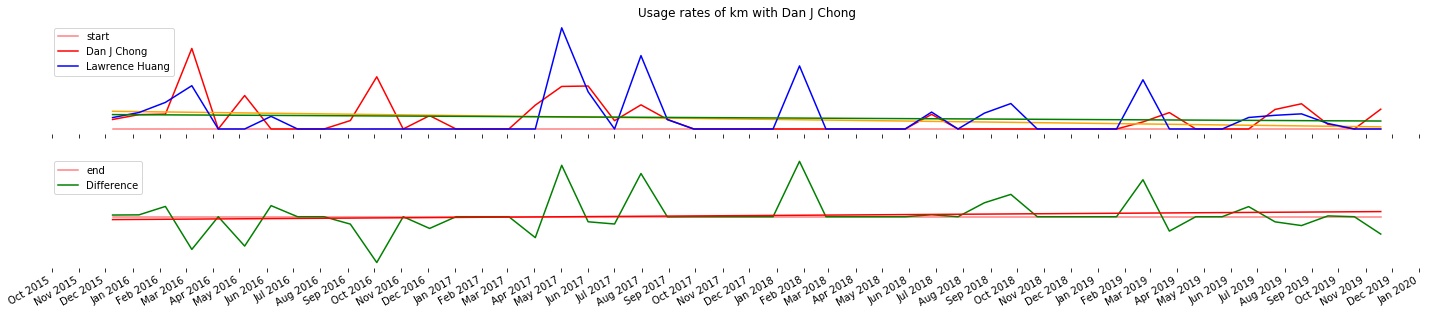

TERM: jk
Influence score: 0.0002822291987486598
user_base_rate: 0.0006670758154899538
friend_base_rate: 0.0006136042660689017
base_difference_rate: 5.3471549421052386e-05
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


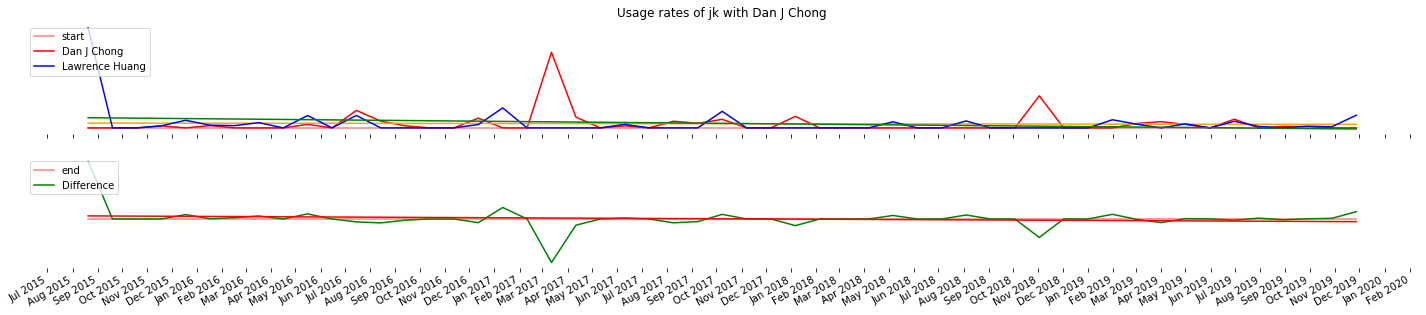

TERM: ('you', 'guys')
Influence score: -0.00015858259492956448
user_base_rate: 0.0007537520710016584
friend_base_rate: 0.00030392189546290307
base_difference_rate: 0.0004498301755387553
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


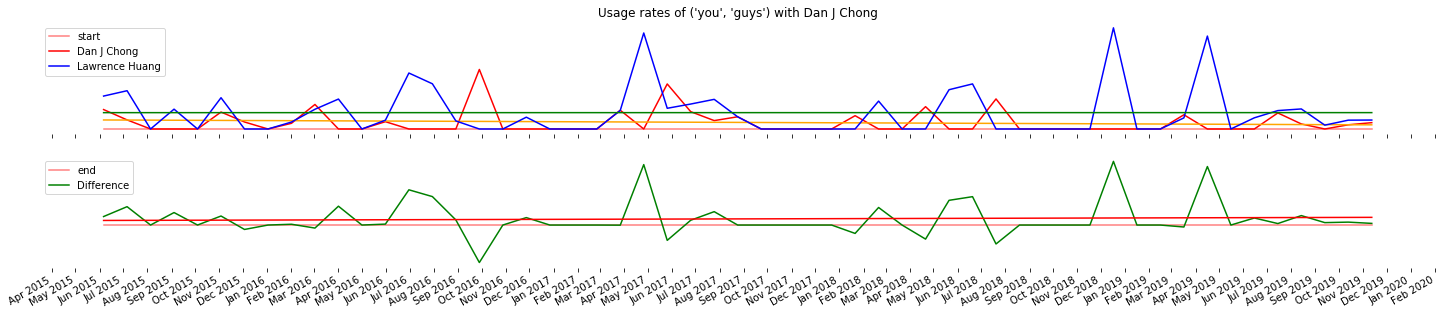

TERM: ('wanted', 'to')
Influence score: -4.676347000860592e-05
user_base_rate: 0.00035734842679944546
friend_base_rate: 0.000303137294788496
base_difference_rate: 5.4211132010949494e-05
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


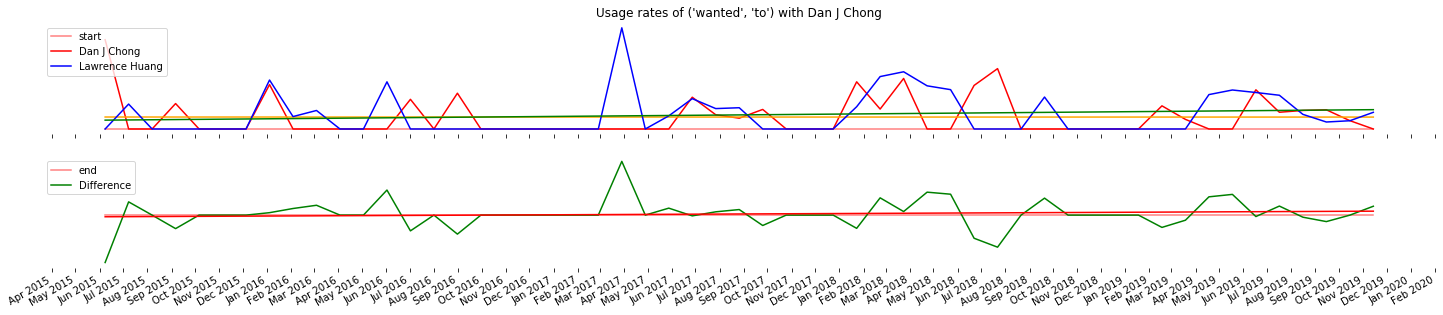

TERM: omg
Influence score: -0.0005967356618233245
user_base_rate: 1.482535684314493e-05
friend_base_rate: 0.00032041843943845567
base_difference_rate: -0.0003055930825953108
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


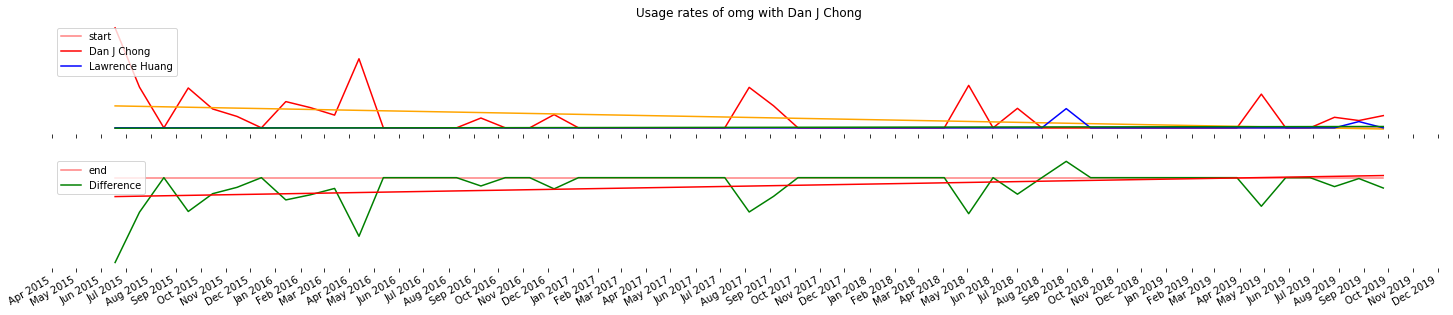

TERM: nvm
Influence score: -0.00017128142798365388
user_base_rate: 0.00036594728365299544
friend_base_rate: 0.0003097817171643644
base_difference_rate: 5.6165566488631e-05
positive influence score = you influenced the other person
negative influence score = the other person influenced you.


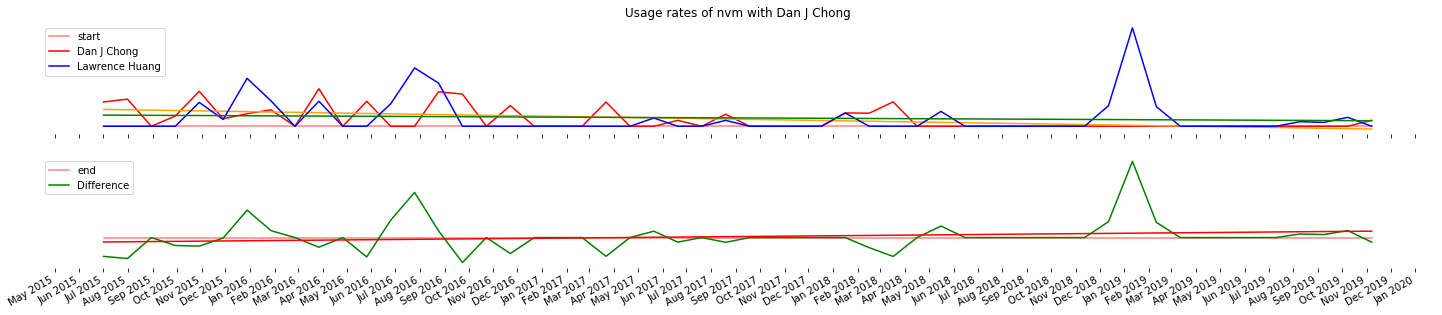

lol: 0.036371671813725116
fuck: -0.8240332007548148
ok: -0.028880547018564087
shit: -0.6715635369463924
gonna: -0.006558531410596828
wanna: -0.002961145538419324
wtf: -0.03758232086796706
lmao: -0.015952973946185136
kid: -0.08089565255431716
okay: 0.02279362705510687
idk: 0.02133531849988957
btw: -0.04838745909171642
nah: 0.007118885102419364
lawrence: 0.015420102603124762
lmfao: 0.000934252561192649
xd: -0.0017385891359750886
aditya: 0.015622586146198008
('im', 'gonna'): -0.014055187460851288
rofl: 0.024508622524707632
('lol', 'i'): -0.005357452891229292
email: 0.005829493865786976
mom: 0.004330606598993863
fk: -0.017348332651289575
addy: -0.0035983069950800955
kinda: -0.003120137493328749
avi: 0.012695825088825548
('holy', 'shit'): -0.31044269120229073
rutgers: 0.005198459356997762
('the', 'fuck'): -0.001189390710635903
korean: -0.0009423853097036897
pls: -0.004895071184626956
kys: 0.0030303421942856627
('oh', 'shit'): -0.0036890079242912124
haha: 0.004581727451361448
km: -0.00710463

In [11]:
# loads term_to_usage_rates from disk

term_to_usage_rates = pickle.load(open(term_to_usage_rates_fname, "rb"))
# { 
#   "FRIEND_NAME": "",
#   term_1: {
#     "friend_usage_rates": [ ... ],
#     "user_usage_rates": [ ... ],
#     "x_axis": x_axis
#   },
#   term_2 : {
#     ...
#   }
# ...
# }
term_to_influence_score = {}

for TERM in term_to_usage_rates:
    if TERM == FRIEND_NAME:
        print(f"Friend name: {FRIEND_NAME}")
        continue

    friend_usage_rates = np.asarray(term_to_usage_rates[TERM]["friend_usage_rates"])
    user_usage_rates = np.asarray(term_to_usage_rates[TERM]["user_usage_rates"])
    x_axis = np.asarray(term_to_usage_rates[TERM]["x_axis"])

    # added to enable code folding
    if True:
        # difference: negative means friend influenced user
        difference = user_usage_rates - friend_usage_rates

        # Create the base line
        start = x_axis[0]
        stop = x_axis[-1]

        # timestamps in seconds
        x_timestamps = np.array([dt.replace(tzinfo=timezone.utc).timestamp() for dt in x_axis])

        # time range covered by data
        total_time = np.ptp(x_timestamps)
        avg_diff = np.mean(abs(difference))

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=x_timestamps, y=difference)
        user_slope, user_intercept, _, _, _ = scipy.stats.linregress(x=x_timestamps, y=user_usage_rates)
        friend_slope, friend_intercept, _, _, _ = scipy.stats.linregress(x=x_timestamps, y=friend_usage_rates)

        # make all difference values positive
        difference_iqr = scipy.stats.iqr(difference)
        
        # make sure this value is positive
        if difference_iqr > 0:
            # the intercept is the value all the way at unix time 0, not when starting
            # this measure the base difference rate
            base_difference_rate = np.mean(difference[:max(len(difference // 10), 1)])
            
            # normalize the scope to calculate influence score
            # divide by difference_iqr to normalize values 
            # multiply by absolute value of base_difference rate to account for whether there is a 
            # initial difference
            influence_score = -slope * total_time / difference_iqr * abs(base_difference_rate)
            
#             tried doing base rates from intercept, not accurate, switching to average over first 10th
#             user_base_rate = user_intercept + x_timestamps[0] * user_slope
#             friend_base_rate = friend_intercept + x_timestamps[0] * friend_slope

            user_base_rate = np.mean(user_usage_rates[:max(len(user_usage_rates // 10), 1)])
            friend_base_rate = np.mean(friend_usage_rates[:max(len(friend_usage_rates // 10), 1)])
            
            term_to_influence_score[TERM] = {"score": influence_score, 
                                             "user_base_rate": user_base_rate, 
                                             "friend_base_rate": friend_base_rate}
                
            # added to enable code folding
#             graph = True
            graph = True
            if graph:
                # 0 slope means there was little influence
                print(f"TERM: {TERM}")
                print(f"Influence score: {influence_score}")
                print("user_base_rate:", user_base_rate)
                print("friend_base_rate:", friend_base_rate)
                print("base_difference_rate:", base_difference_rate)
#                 print(f"Your usage rate slope: {user_slope}")
#                 print(f"Their usage rate slope: {friend_slope}")
#                 print(f"Diff slope: {slope}")
#                 print(f"Diff IQR: {difference_iqr}")
                
                print("""positive influence score = you influenced the other person\nnegative influence score = the other person influenced you.""")
                # (aka your usage rate was initially higher than the other person)

                # negative influence score = the other person influenced you.
                # (aka your usage rate was initially lower than the other person

                fig, ax = plt.subplots(nrows=2, figsize=(25, 5))
                
                # TODO: set the y_lim dynamically, works well enough for now
#                 for i in range(len(ax)):
#                     ax[i].set_ylim(bottom=-0.03, top=0.03)
                
                ax[0].plot((start, stop), (0, 0), 'r', alpha=.5, label="start")
                ax[1].plot((start, stop), (0, 0), 'r', alpha=.5, label="end")

                ax[0].set(title=f"Usage rates of {TERM} with {FRIEND_NAME}")
                ax[0].plot(x_axis, friend_usage_rates, label=f"{FRIEND_NAME}", c='r')
                ax[0].plot(x_axis, friend_intercept + friend_slope*x_timestamps, c='orange')
                ax[0].plot(x_axis, user_usage_rates, label=f"{account_user_name}", c='b')
                ax[0].plot(x_axis, user_intercept + user_slope*x_timestamps, c='green')
                
#                 plot user base rate as sanity check
#                 ax[0].plot((x_axis[0]), (user_base_rate), 'ko', alpha=1, label="int")
                
                
                ax[1].plot(x_axis, difference, label="Difference", c='green')
                ax[1].plot(x_axis, intercept + slope*x_timestamps, c='red')

                for i in range(len(ax)):
                    ax[i].get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
                    ax[i].get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
                    fig.autofmt_xdate()

                    plt.setp((ax[i].get_yticklabels() + ax[i].get_yticklines() +
                                  list(ax[i].spines.values())), visible=False)

                    ax[i].legend(loc='upper left');
                plt.show()

normalized_scores = np.asarray([term_to_influence_score[x]["score"] for x in term_to_influence_score])
normalized_scores = scipy.stats.zscore(normalized_scores)
counter = 0

total_term_count = 0
for TERM in term_to_influence_score:
    total_term_count += sender_to_term_count[friend_name][TERM]

for TERM in term_to_influence_score:
    cur_term_score = normalized_scores[counter]
    counter += 1
    
    # TODO: normalize by what the affected person's initial usage rate was,
    # if the affected person's initial usage rate was high, the influence score should be low
    # if the affected person's initial usage rate was low, the influence score should be high
    
    # middle 15% of data
    if cur_term_score < 0: # neg: them -> you
        term_to_influence_score[TERM]["score"] /= abs(term_to_influence_score[TERM]["user_base_rate"])
    elif cur_term_score > 0: # pos: you -> them
        term_to_influence_score[TERM]["score"] /= abs(term_to_influence_score[TERM]["friend_base_rate"])
    
    # weight by term count
    term_to_influence_score[TERM]["score"] *= sender_to_term_count[friend_name][TERM] / total_term_count
    
    print(f'{TERM}: {term_to_influence_score[TERM]["score"]}')

In [ ]:
# run the influence calculation for top 20 friends and their top 20 terms, store to disk